In [1]:
import gc

import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import Hyperband

import matplotlib.pyplot as plt
import numpy as np

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


## CNN CIFAR

In [2]:
from keras.optimizers.legacy import Adam

In [3]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [5]:
batch_size = 128
classes = 10
epochs = 10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
input_shape = (32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

In [6]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


## TUNER


In [7]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

# Define a HyperModel
class MyHyperModel(HyperModel):
    def __init__(self, input_shape, classes):
        self.input_shape = input_shape
        self.classes = classes

    def build(self, hp):
        input = Input(shape=self.input_shape, name='Input')
        x = input

        # Allow Keras Tuner to decide the number of convolutional layers
        for i in range(hp.Int('conv_layers', 1, 3)):
            x = Conv2D(filters=8 * (2 ** i),
                       kernel_size=(3, 3),
                       padding='same',
                       activation='relu',
                       name=f'Conv2D-{i + 1}')(x)
            x = MaxPool2D(pool_size=(2, 2), padding='same', name=f'MaxPool2D-{i + 1}')(x)

            # Allow Keras Tuner to decide whether to use dropout
            if hp.Boolean('conv_dropout'):
                x = Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1), name=f'Dropout-{i + 1}')(x)

        x = Flatten(name='Flatten')(x)
        output = Dense(units=self.classes, activation='softmax', name='Output')(x)
        model = Model(inputs=input, outputs=output)

        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

# Function to search for best hyperparameters
def search_best_hyperparameters(input_shape, classes, X_train, Y_train, epochs, batch_sizes=[64, 128, 256, 512]):
    np.random.seed(1402)
    tf.random.set_seed(1981)
    
    best_batch_size = None
    best_val_accuracy = 0
    
    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
        hypermodel = MyHyperModel(input_shape=input_shape, classes=classes)

        tuner = Hyperband(
            hypermodel,
            objective='val_accuracy',
            max_epochs=10,
            directory='fashion_cifar',
            project_name='final_really'+str(batch_size)
        )

        tuner.search(x=X_train, y=Y_train, epochs=epochs, callbacks=[early_stopping], batch_size=batch_size, validation_split=0.1)

        
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        val_accuracy = best_trial.score
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_batch_size = batch_size
            
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    The hyperparameter search is complete. The optimal number of convolutional layers is {best_hps.get('conv_layers')}
    and the optimal dropout rate is {best_hps.get('dropout_rate')} and optimal batch size is {best_batch_size}.
    """)

    return best_hps, tuner



In [8]:
best_hps, tuner = search_best_hyperparameters(input_shape, classes, X_train, Y_train, epochs = 10)

Trial 30 Complete [00h 00m 27s]
val_accuracy: 0.5374000072479248

Best val_accuracy So Far: 0.5716000199317932
Total elapsed time: 00h 05m 04s

    The hyperparameter search is complete. The optimal number of convolutional layers is 3
    and the optimal dropout rate is 0.5 and optimal batch size is 64.
    


In [22]:
best_model = tuner.hypermodel.build(best_hps)

In [21]:
import json
tuner.get_best_hyperparameters(num_trials=1)[0]
json_str = json.dumps(best_hps.values, indent=4)

# Print the pretty-printed JSON string
print(json_str)

{
    "conv_layers": 3,
    "conv_dropout": false,
    "dropout_rate": 0.5,
    "tuner/epochs": 10,
    "tuner/initial_epoch": 0,
    "tuner/bracket": 0,
    "tuner/round": 0
}


In [23]:
history = best_model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=0.1)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2672 - loss: 2.0006 - val_accuracy: 0.4496 - val_loss: 1.5491
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4580 - loss: 1.5104 - val_accuracy: 0.5118 - val_loss: 1.3819
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5079 - loss: 1.3795 - val_accuracy: 0.5418 - val_loss: 1.3001
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5388 - loss: 1.3008 - val_accuracy: 0.5632 - val_loss: 1.2397
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5633 - loss: 1.2365 - val_accuracy: 0.5804 - val_loss: 1.2055
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5811 - loss: 1.1839 - val_accuracy: 0.5932 - val_loss: 1.1727
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5978 - loss: 1.1401 - val_accuracy: 0.6070 - val_loss: 1.1355
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6135 - loss: 1.1037 - val_accuracy:

In [24]:
hs_eval = best_model.evaluate(X_test, Y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6677 - loss: 0.9444


In [25]:
hs_eval

[0.9631901383399963, 0.6674000024795532]

In [31]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

Train Loss     : 0.82433
Validation Loss: 0.95193
Test Loss      : 0.96319
---
Train Accuracy     : 0.71496
Validation Accuracy: 0.67580
Test Accuracy      : 0.66740



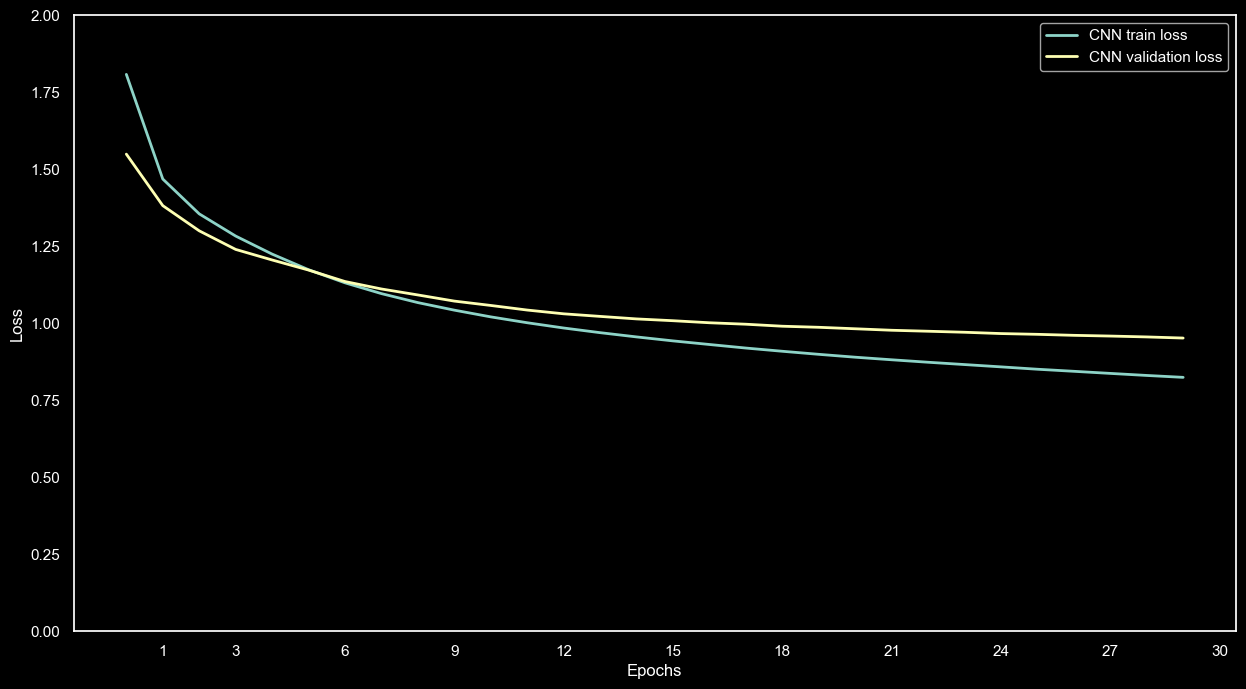

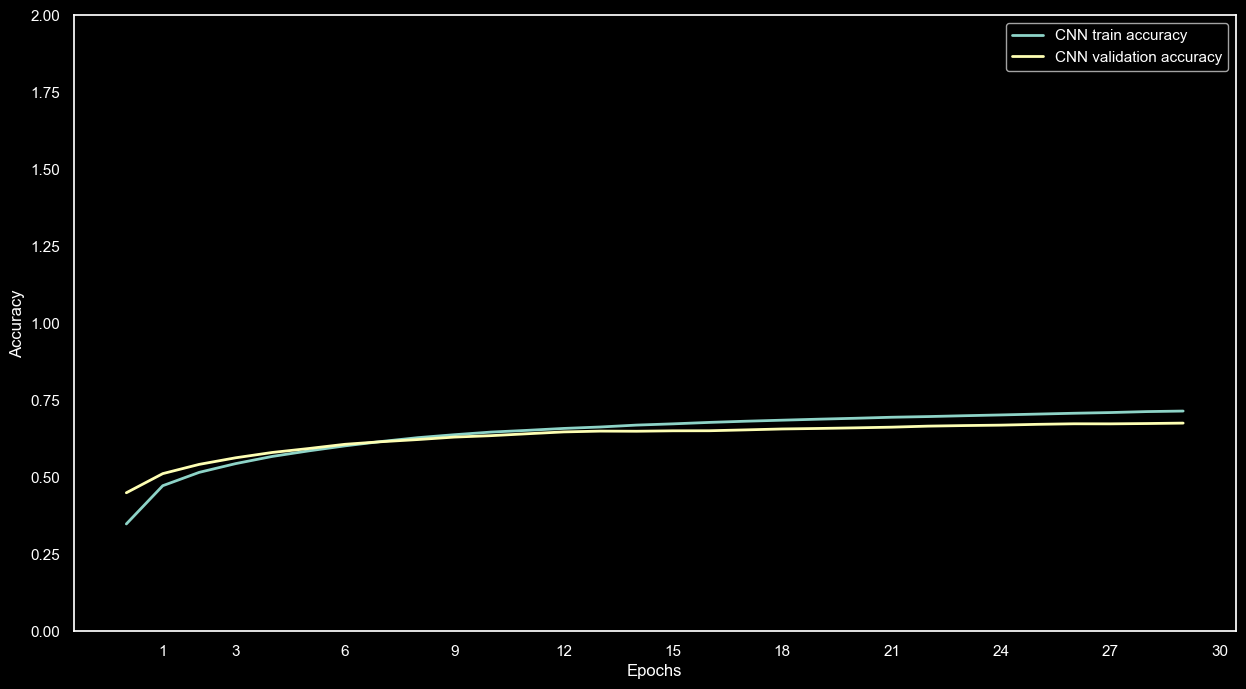

In [32]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(hs_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(hs_eval[1]))

# Plot train and validation error per epoch.
plot_history(hs={'CNN': history}, epochs=30, metric='loss')
plot_history(hs={'CNN': history}, epochs=30, metric='accuracy')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


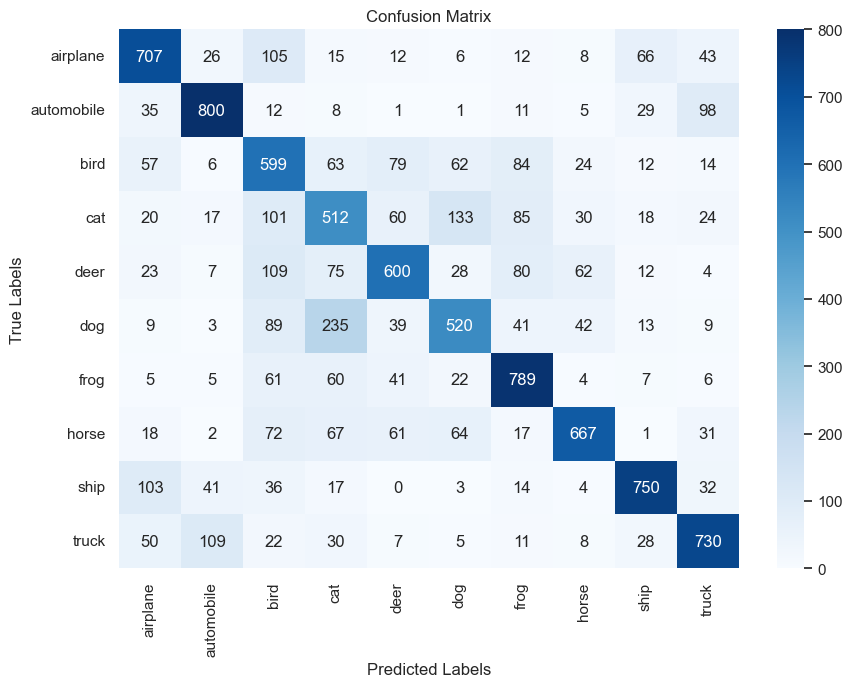

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `predictions` are the raw outputs from your model, e.g., softmax probabilities
# Convert predictions and true labels from one-hot encoded to class indices
predictions = np.argmax(best_model.predict(X_test), axis=-1)
y_test_indices = np.argmax(Y_test, axis=-1)  # Only if y_test is one-hot encoded

sns.set_theme(style="white")
# Calculate the confusion matrix
cm = confusion_matrix(y_test_indices, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming your model's prediction function returns the class probabilities
predictions_prob = best_model.predict(X_test)  # Get model predictions for the test set

# Convert probabilities to predicted class labels
predictions = np.argmax(predictions_prob, axis=1)

# Assuming y_test is one-hot encoded, convert it to single integer labels
y_true = np.argmax(Y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, predictions, target_names=class_names)

print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

    airplane       0.69      0.71      0.70      1000
  automobile       0.79      0.80      0.79      1000
        bird       0.50      0.60      0.54      1000
         cat       0.47      0.51      0.49      1000
        deer       0.67      0.60      0.63      1000
         dog       0.62      0.52      0.56      1000
        frog       0.69      0.79      0.74      1000
       horse       0.78      0.67      0.72      1000
        ship       0.80      0.75      0.77      1000
       truck       0.74      0.73      0.73      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



In [35]:
misclassified_indices = np.where(predictions_prob != y_test)[0]
y_test_class_indices = np.argmax(Y_test, axis=1)

In [36]:
def plot_images(images, titles, pred_class_name, nrows=1, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    fig.suptitle(f"Misclassified as: {pred_class_name}", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()



[40 54 76]


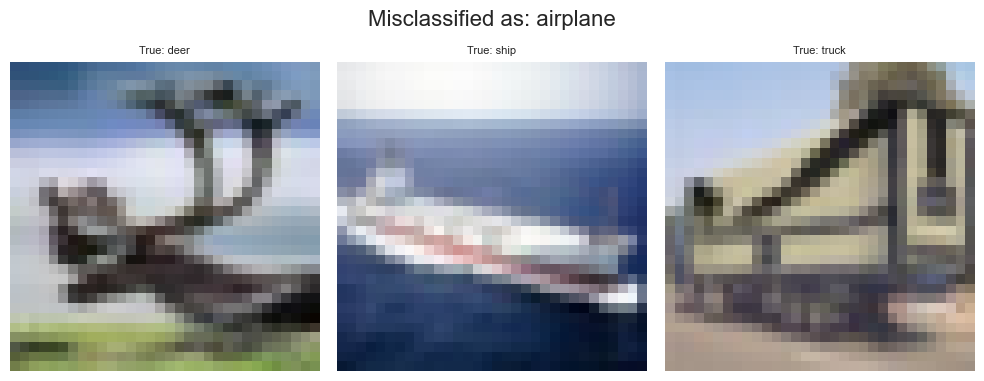

[ 23 150 211]


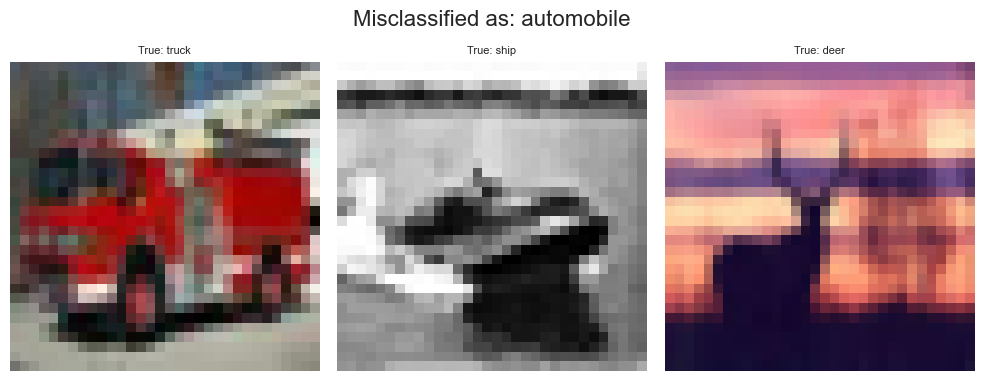

[ 7 20 22]


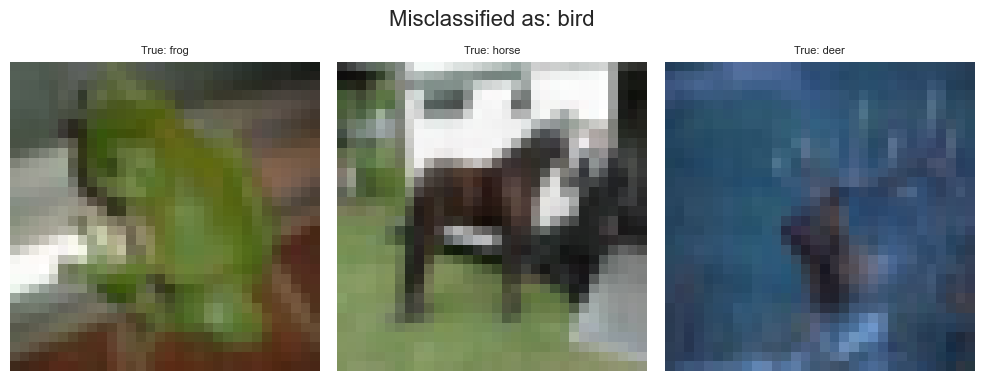

[17 33 42]


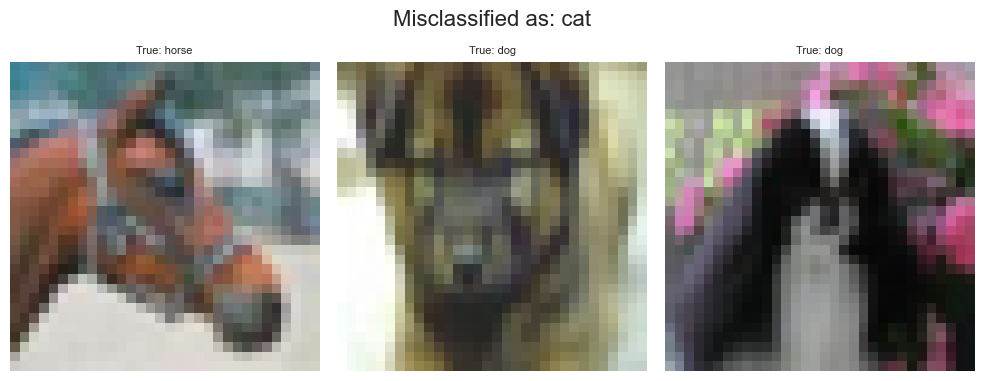

[ 24 115 195]


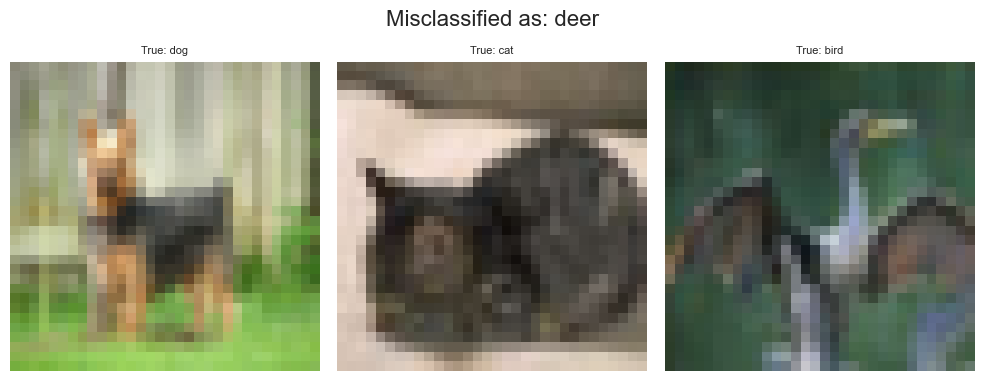

[57 61 68]


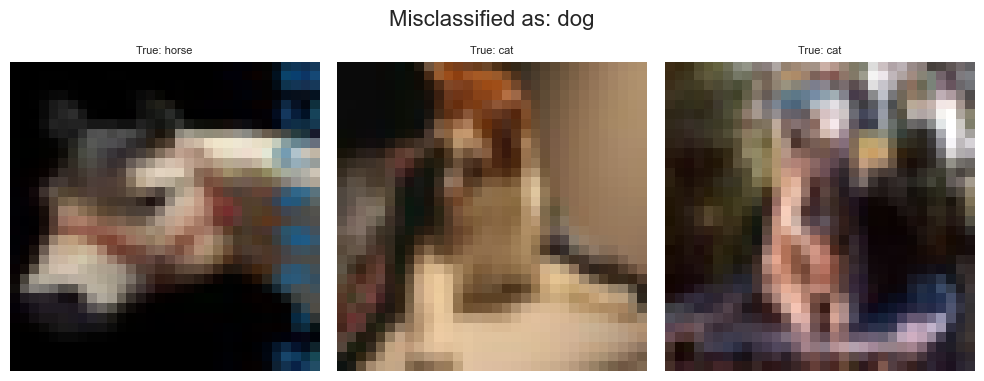

[12 15 35]


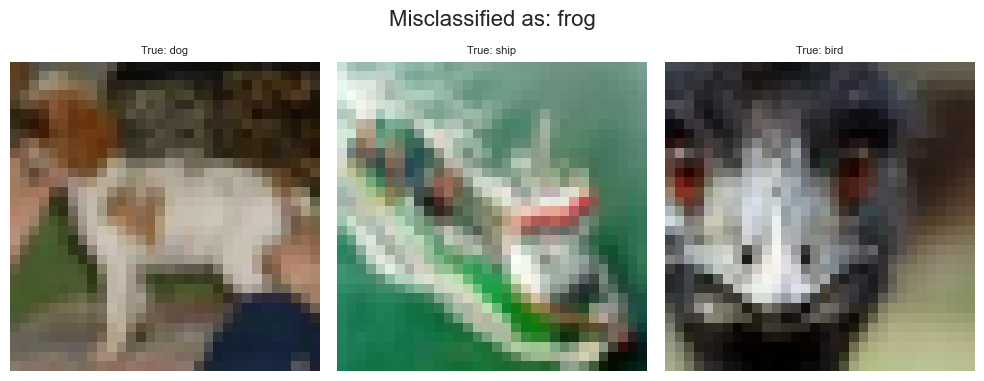

[ 36  85 108]


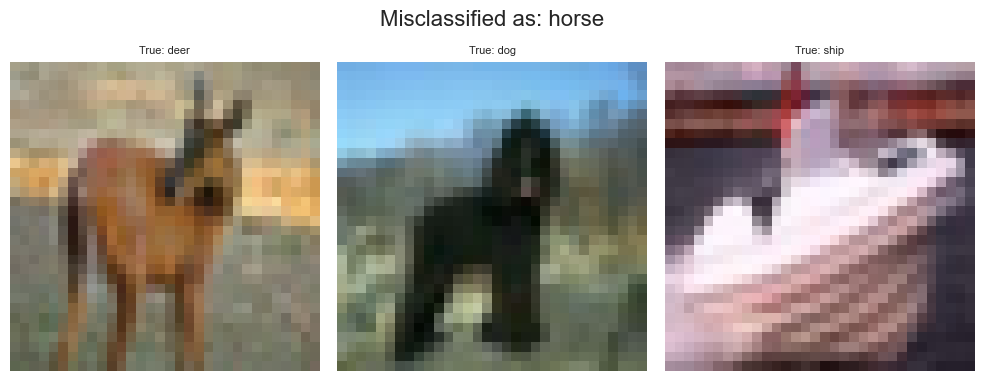

[  0  67 139]


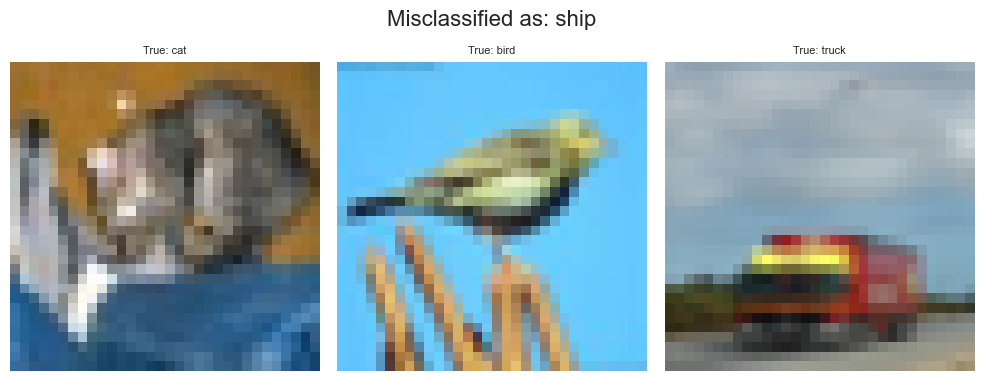

[ 63  74 179]


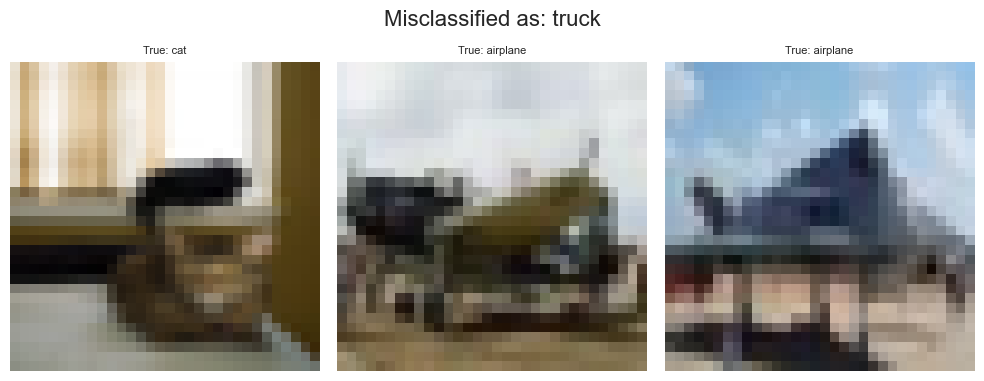

In [37]:
for pred_class_idx, pred_class_name in enumerate(class_names):
    # Find indices where the prediction was pred_class_idx but the true class was different
    misclassified_indices = np.where((predictions == pred_class_idx) &
                                     (y_test_class_indices != pred_class_idx))[0]

    # Select a subset of misclassified images for this predicted class
    subset_indices = misclassified_indices[:3]  # Adjust as needed
    print(subset_indices)
    if len(subset_indices) > 0:
        # Ensure images are reshaped from (784,) to (32, 32) for plotting
        images = [X_test[i].reshape(32, 32, 3) for i in subset_indices]
        titles = [f"True: {class_names[y_test_class_indices[i]]}" for i in subset_indices]

        plot_images(images, titles, pred_class_name)

In [38]:
best_model.summary() 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-1 (Conv2D)               │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-1 (MaxPooling2D)      │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-2 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-2 (MaxPooling2D)      │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-3 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-3 (MaxPooling2D)      │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,488 (130.82 KB)

 Trainable params: 11,162 (43.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,326 (87.21 KB)